In [ ]:
import torch
print("PyTorch:", torch.__version__)


PyTorch: 2.6.0+cu124


In [ ]:
print("CUDA disponible:", torch.cuda.is_available())
print("Versión CUDA de PyTorch:", torch.version.cuda)

CUDA disponible: True
Versión CUDA de PyTorch: 12.4


In [ ]:
def configurar_estilo_graficas():
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import seaborn as sns

    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.4)

    # Tamaño del texto
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['legend.fontsize'] = 12
    mpl.rcParams['legend.title_fontsize'] = 13

    # DPI por defecto al guardar imágenes
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['savefig.bbox'] = 'tight'  # recorta márgenes automáticamente

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Bloque bottleneck para ResNet50
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # Primera capa 1x1: reducción de dimensionalidad
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # Segunda capa 3x3
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # Tercera capa 1x1: restauración de dimensionalidad
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Si es necesario, se aplica downsample para igualar dimensiones
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

# Definición de la arquitectura ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Capa inicial: convolución 7x7, BatchNorm, ReLU y max pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Etapas con bloques bottleneck
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Capa final: Global Average Pooling y capa Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # Función para construir cada etapa de bloques
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        # Se realiza un downsample si las dimensiones cambian
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Función para instanciar la ResNet50
def resnet50(num_classes=7):
    # La distribución de bloques para ResNet50 es: [3, 4, 6, 3]
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

# Ejemplo de uso
if __name__ == "__main__":
    model = resnet50()
    # Entrada de ejemplo: batch de 1 imagen de 224x224 con 3 canales
    x = torch.randn(1, 3, 224, 224)
    print(model(x).shape)  # Salida: torch.Size([1, 1000])


torch.Size([1, 7])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Transformaciones para el conjunto de entrenamiento (con data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformaciones para el conjunto de validación (sin data augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Cargar datasets usando ImageFolder
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data_reducida/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data_reducida/validation', transform=val_transform)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:

# Instanciar el modelo ResNet50 adaptado para 7 clases
model = resnet50(num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Visualizar capas del modelo

In [ ]:
#!pip install torchview

In [ ]:
# from torchvision.models import resnet50
# from torchview import draw_graph

# model = resnet50(num_classes=7)
# model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# model_graph.visual_graph.render("resnet50_graph", format="png")


In [ ]:
#!pip install torchview

In [ ]:
# from torchvision.models import resnet50
# from torchview import draw_graph

# model = resnet50(num_classes=7)
# graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# graph.visual_graph.render("resnet50_diagram", format="png")  # Guarda como imagen


In [ ]:
# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 50
train_losses = []     # Para almacenar la pérdida en entrenamiento en cada época
val_losses = []       # Para almacenar la pérdida en validación en cada época
train_acc_list = []   # Para almacenar la precisión en entrenamiento en cada época
val_acc_list = []     # Para almacenar la precisión en validación en cada época

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Bucle de entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train

    # Evaluación en el conjunto de validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

            # poner una validación para mejor resultado de la pérdida de la validación o el accuracy

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    train_acc_list.append(epoch_acc)
    val_acc_list.append(val_epoch_acc)

    #np.savez('training_results.npz',
        #  train_losses=train_losses,
        #  val_losses=val_losses,
        #  train_acc_list=train_acc_list,
        #  val_acc_list=val_acc_list)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    print(f"  Val   - Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")


Epoch 1/50:
  Train - Loss: 0.3383, Acc: 0.8744
  Val   - Loss: 0.2938, Acc: 0.9046
Epoch 2/50:
  Train - Loss: 0.1286, Acc: 0.9591
  Val   - Loss: 0.1138, Acc: 0.9643
Epoch 3/50:
  Train - Loss: 0.0999, Acc: 0.9690
  Val   - Loss: 0.1407, Acc: 0.9563
Epoch 4/50:
  Train - Loss: 0.0836, Acc: 0.9734
  Val   - Loss: 0.0755, Acc: 0.9768
Epoch 5/50:
  Train - Loss: 0.0724, Acc: 0.9776
  Val   - Loss: 0.0662, Acc: 0.9785
Epoch 6/50:
  Train - Loss: 0.0637, Acc: 0.9796
  Val   - Loss: 0.1278, Acc: 0.9571
Epoch 7/50:
  Train - Loss: 0.0588, Acc: 0.9811
  Val   - Loss: 0.1085, Acc: 0.9665
Epoch 8/50:
  Train - Loss: 0.0531, Acc: 0.9829
  Val   - Loss: 0.0642, Acc: 0.9776
Epoch 9/50:
  Train - Loss: 0.0534, Acc: 0.9829
  Val   - Loss: 0.0619, Acc: 0.9803
Epoch 10/50:
  Train - Loss: 0.0457, Acc: 0.9852
  Val   - Loss: 0.1226, Acc: 0.9598
Epoch 11/50:
  Train - Loss: 0.0393, Acc: 0.9881
  Val   - Loss: 0.0594, Acc: 0.9795
Epoch 12/50:
  Train - Loss: 0.0356, Acc: 0.9882
  Val   - Loss: 0.0627, A

In [ ]:
# Guardar el modelo (por ejemplo, al finalizar el entrenamiento)
torch.save(model.state_dict(), "resnet50_model.pth")


In [ ]:
# Para cargar el modelo:
model = resnet50(num_classes=7)  # Asegúrate de inicializar la arquitectura
model.load_state_dict(torch.load("resnet50_model.pth"))
model.eval()  # Poner el modelo en modo evaluación si se va a usar para inferencia

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Batc

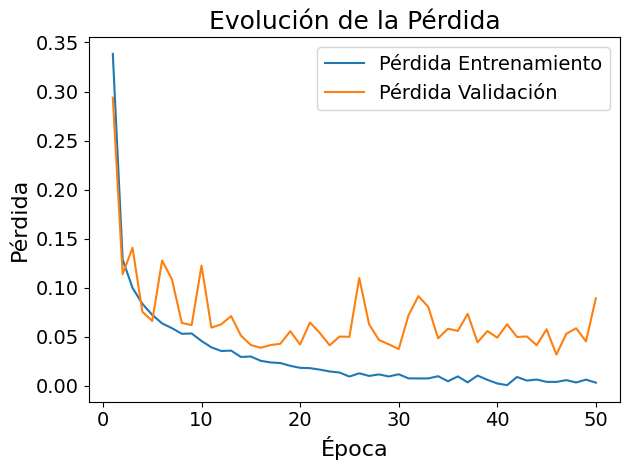

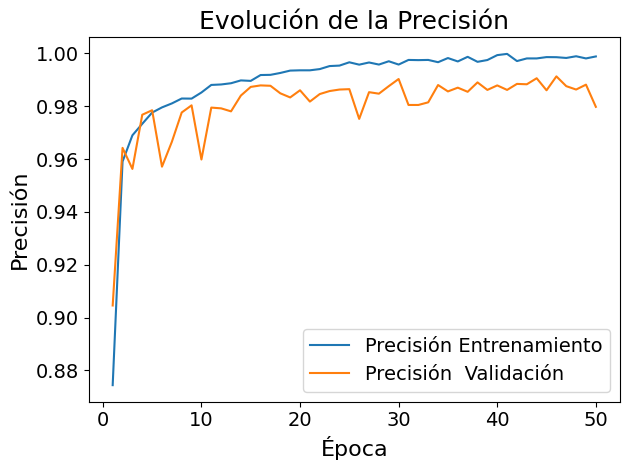

In [ ]:
epochs = range(1, num_epochs + 1)

#plt.figure(figsize=(12, 5))

# Gráfico de Pérdida
#plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Pérdida Entrenamiento')
plt.plot(epochs, val_losses, label='Pérdida Validación')
plt.title('Evolución de la Pérdida',fontsize=18)
plt.xlabel('Época',fontsize=16)
plt.ylabel('Pérdida',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("perdida_resnet50.png", dpi=300, bbox_inches="tight")
plt.show()

# Gráfico de Precisión
#plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Precisión Entrenamiento')
plt.plot(epochs, val_acc_list, label='Precisión  Validación')
plt.title('Evolución de la Precisión',fontsize=18)
plt.xlabel('Época',fontsize=16)
plt.ylabel('Precisión',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("precision_resnet50.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Para cargar el modelo:
model = resnet50(num_classes=7)  # Asegúrate de inicializar la arquitectura
model.load_state_dict(torch.load("resnet50_model.pth"))

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Durante el entrenamiento o la inferencia:
images = images.to(device)
labels = labels.to(device)


In [ ]:
import torch
import torch.nn.functional as F

# Inicializar listas para almacenar etiquetas y embeddings
all_labels = []
features = []
all_preds = []

# Poner el modelo en modo evaluación
model.eval()

# Definir una función para extraer las características de la última capa convolucional
def hook_fn(module, input, output):
    features.append(output.detach().cpu())

# Conectar el hook a la capa deseada (última convolucional)
hook = model.layer4.register_forward_hook(hook_fn)  # Ajusta según el modelo

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Convertir a CPU y agregar etiquetas y predicciones
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Concatenar las características de todos los batches
all_features = torch.cat(features, dim=0)
print("Dimensiones totales de las características extraídas:", all_features.shape)

# Cuando ya no se necesite el hook, se elimina
hook.remove()


Dimensiones totales de las características extraídas: torch.Size([7022, 2048, 7, 7])


In [ ]:
from sklearn.metrics import f1_score, classification_report

# Calcular el F1-score (puedes cambiar el parámetro 'average' según tus necesidades)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Generar un reporte de métricas completo
report = classification_report(all_labels, all_preds, target_names=val_dataset.classes)
print(report)

F1 Score: 0.9798
              precision    recall  f1-score   support

         015       1.00      0.97      0.98      1001
         030       0.99      0.99      0.99      1003
         045       0.98      1.00      0.99      1004
         060       0.99      0.96      0.98      1002
         075       0.93      0.99      0.96      1005
         090       1.00      0.95      0.97      1001
         180       0.98      1.00      0.99      1006

    accuracy                           0.98      7022
   macro avg       0.98      0.98      0.98      7022
weighted avg       0.98      0.98      0.98      7022



In [ ]:
#print(all_features)

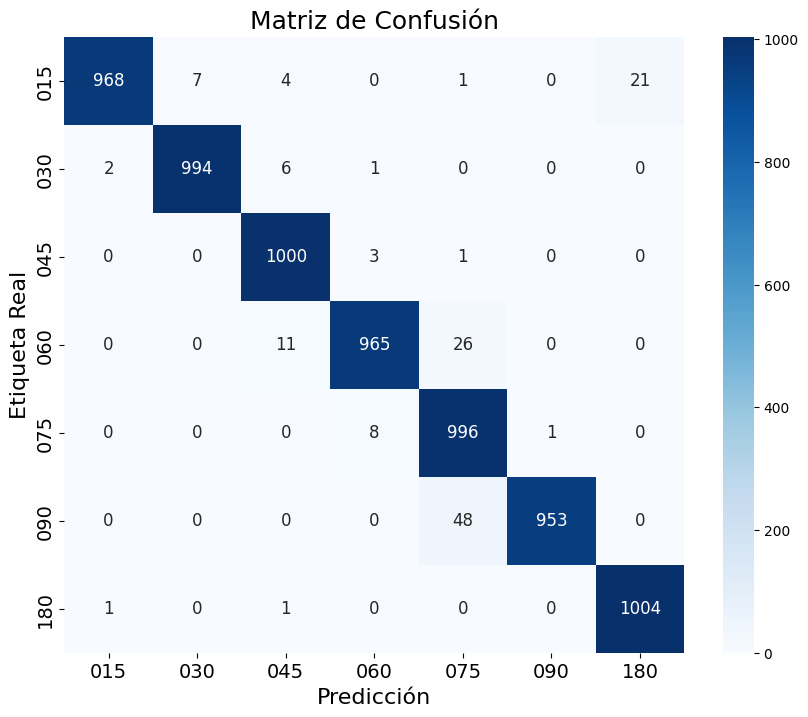

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Visualizar el mapa de calor de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_dataset.classes, yticklabels=val_dataset.classes,annot_kws={"size": 12})
plt.title("Matriz de Confusión",fontsize=18)
plt.xlabel("Predicción",fontsize=16)
plt.ylabel("Etiqueta Real",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("matriz_confusion_resnet50.png", dpi=300, bbox_inches="tight")
plt.show()

GradCAM

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


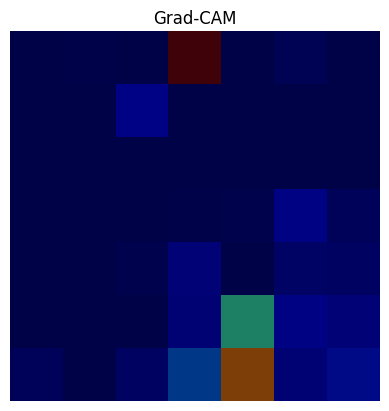

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Registrar hooks para capturar activaciones y gradientes
        self.forward_handle = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_handle = self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Asegurarse de que el modelo esté en modo evaluación
        self.model.eval()
        # Realizar forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output[0].argmax().item()
        # Realizar backward pass solo para la clase objetivo
        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        # Calcular los pesos: promedio global de los gradientes en cada canal
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        # Combinar las activaciones con los pesos para obtener el CAM
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        # Aplicar ReLU y normalizar
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

    def remove_hooks(self):
        self.forward_handle.remove()
        self.backward_handle.remove()

# Uso de Grad-CAM:
# Supongamos que 'model' es tu ResNet50 y deseas utilizar la última capa convolucional del layer4.
target_layer = model.layer4[-1]  # Por ejemplo, la última sub-capa del bloque layer4
grad_cam = GradCAM(model, target_layer)

# Prepara una imagen de entrada (asegúrate de que ya esté normalizada según el modelo)
input_tensor = images[0:1].to(device)  # 'images' es un batch con tamaño [1, 3, 224, 224]

# Genera el mapa Grad-CAM para la clase predicha
cam = grad_cam(input_tensor)

# Visualización del mapa Grad-CAM superpuesto a la imagen original
img = input_tensor[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())  # Normalizar para visualización

plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)  # Superpone el mapa con transparencia
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

# No olvides remover los hooks cuando ya no los necesites:
grad_cam.remove_hooks()



In [ ]:
import torch.nn.functional as F

# all_features tiene forma [7022, 2048, 7, 7]
# Aplicar pooling global para obtener un vector de cada imagen: [7022, 2048]
features_vector = F.adaptive_avg_pool2d(all_features, (1, 1)).squeeze()
# Si squeeze elimina más de las dimensiones deseadas, asegúrate de que la salida sea [7022, 2048]:
if features_vector.dim() > 2:
    features_vector = features_vector.view(features_vector.size(0), -1)

print("Dimensiones de features_vector:", features_vector.shape)
# Ahora, features_vector tiene forma [7022, 2048]
features_np = features_vector.numpy()

Dimensiones de features_vector: torch.Size([7022, 2048])


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

# all_features: array de forma [N, D] (N muestras, D dimensión de características)
# all_labels: array de tamaño [N] con las etiquetas verdaderas

# Entrenar LDA sobre las características extraídas
lda = LinearDiscriminantAnalysis()
lda= lda.fit(features_np, all_labels)

# Realizar predicciones y calcular el CCR
lda_preds = lda.predict(features_np)
ccr = accuracy_score(all_labels, lda_preds)
print("CCR (tasa de clasificación correcta) con LDA:", ccr)

CCR (tasa de clasificación correcta) con LDA: 0.9990031330105383


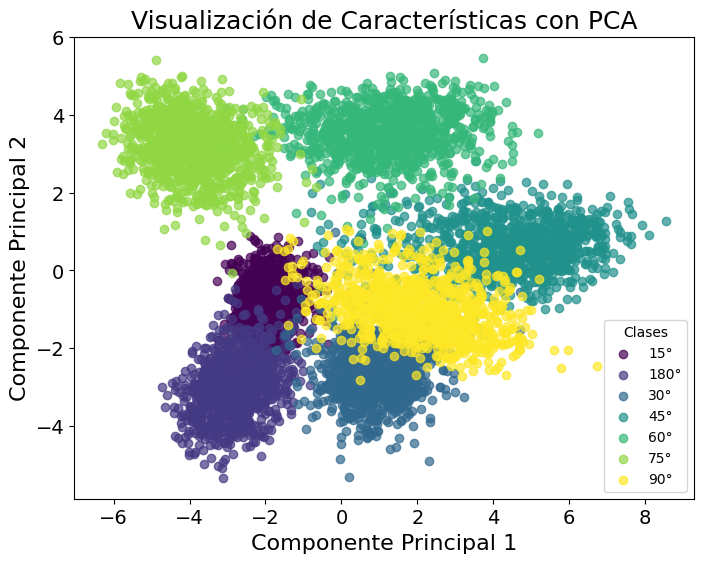

In [ ]:

unique_classes = np.unique(all_labels)

class_names = ['15°', '30°', '45°', '60°','75°', '90°','180°']
# paleta de colores para cada una de las clases
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

plt.figure(figsize=(8, 6))
for i, cls in enumerate(unique_classes):
    # Seleccionar los índices de las muestras de la clase actual
    idx = np.where(all_labels == cls)[0]
    # Graficar las proyecciones LDA correspondientes a la clase
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1],
                color=colors[i], label=str(cls), alpha=0.7)


plt.title("Visualización de Características con PCA",fontsize=18)
plt.xlabel("Componente Principal 1",fontsize=16)
plt.ylabel("Componente Principal 2",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(class_names, title="Clases")
plt.savefig("pca_resnet50.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(features_np)  # features_np es el array de características [N, D]
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza explicada acumulada:", pca.explained_variance_ratio_.cumsum())


Varianza explicada por cada componente: [0.2602886  0.18731587 0.16548544 0.1272038  0.10264751]
Varianza explicada acumulada: [0.2602886  0.44760448 0.6130899  0.74029374 0.8429412 ]


In [ ]:
import numpy as np

varianza_PCA_resnet50 = np.array([0.2602886,  0.18731587, 0.16548544, 0.1272038,  0.10264751])
suma_resnet50 = varianza_PCA_resnet50.sum()
print("PCA resnet50:",suma_resnet50)

PCA resnet50: 0.8429412199999999


In [ ]:
print(all_labels)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)

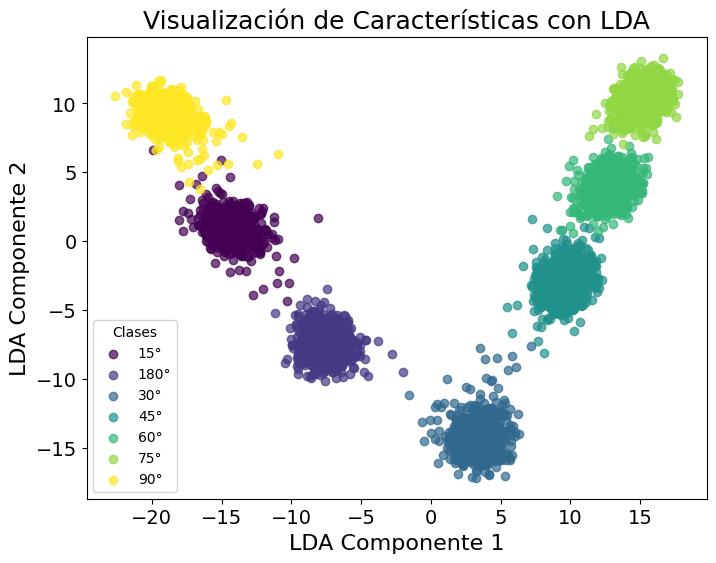

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Generar una paleta de colores (una cantidad de colores igual al número de clases)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))

plt.figure(figsize=(8, 6))
for i, cls in enumerate(unique_classes):
    # Seleccionar los índices de las muestras de la clase actual
    idx = np.where(all_labels == cls)[0]
    # Graficar las proyecciones LDA correspondientes a la clase
    plt.scatter(features_lda[idx, 0], features_lda[idx, 1],
                color=colors[i], label=str(cls), alpha=0.7)

plt.title("Visualización de Características con LDA",fontsize=18)
plt.xlabel("LDA Componente 1",fontsize=16)
plt.ylabel("LDA Componente 2",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(class_names, title="Clases")
plt.savefig("lda_resnet50_2.png",dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

lda = LinearDiscriminantAnalysis()
lda.fit(features_np, all_labels)  # all_labels son las etiquetas verdaderas
preds = lda.predict(features_np)
ccr = accuracy_score(all_labels, preds)
print("CCR (accuracy) de LDA:", ccr)


CCR (accuracy) de LDA: 0.9990031330105383


In [ ]:
from sklearn.cross_decomposition import CCA
import numpy as np

# Simulamos una segunda vista a partir de features_np
np.random.seed(42)
features_np2 = features_np + 0.01 * np.random.randn(*features_np.shape)

# Aplicar CCA para obtener, por ejemplo, 2 componentes
cca = CCA(n_components=2)
cca.fit(features_np, features_np2)
X_c, Y_c = cca.transform(features_np, features_np2)

# Calcular la correlación para cada componente
cca_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Correlaciones canónicas (CCA):", cca_corrs)



/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Correlaciones canónicas (CCA): [np.float64(0.9999924138241615), np.float64(0.9992361489460483)]


In [ ]:
import torch
from sklearn.metrics import accuracy_score

# Supongamos que 'model' es el modelo entrenado, 'criterion' es la función de pérdida,
# y 'val_loader' es el DataLoader del conjunto de validación.

model.eval()  # Poner el modelo en modo evaluación
running_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)

        # Obtener las predicciones
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calcular la pérdida promedio
avg_loss = running_loss / len(val_loader.dataset)

# Calcular el accuracy (precisión)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Validation Loss: {avg_loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Loss: 0.0893
Validation Accuracy: 0.9798


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


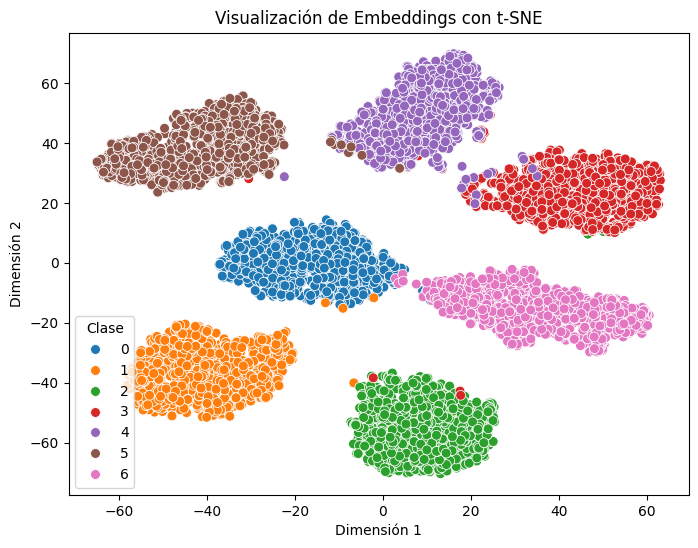

In [ ]:
from sklearn.manifold import TSNE

# Aplicar t-SNE para reducir a 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(features_np)


t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica no lineal de reducción de dimensionalidad usada principalmente para visualización, pero a diferencia de PCA o LDA, no está pensada para generar métricas numéricas directas como varianza explicada o accuracy.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suponiendo que tienes features_np de forma [N, D] y etiquetas all_labels
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features_np)

# Entrenar clasificador sobre coordenadas t-SNE
clf = LogisticRegression()
clf.fit(tsne_features, all_labels)
preds = clf.predict(tsne_features)

acc = accuracy_score(all_labels, preds)
print("CCR (accuracy) en espacio t-SNE:", acc)


CCR (accuracy) en espacio t-SNE: 0.9883224152663059


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


métricas de agrupamiento no supervisado como:

Silhouette Score: qué tan bien separados están los puntos entre clases.

Davies-Bouldin Index: qué tan compactos y separados están los grupos (menor es mejor).

Calinski-Harabasz Score: relación entre dispersión intra/inter grupos (mayor es mejor).

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# tsne_features: [N, 2]
s_score = silhouette_score(tsne_features, all_labels)
db_index = davies_bouldin_score(tsne_features, all_labels)
ch_score = calinski_harabasz_score(tsne_features, all_labels)

print(f"Silhouette Score: {s_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")


Silhouette Score: 0.5961
Davies-Bouldin Index: 0.5698
Calinski-Harabasz Score: 14628.1533


Se puede medir la separabilidad con k-NN con cross-validation sobre coordenadas t-SNE

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=7)
scores = cross_val_score(knn, tsne_features, all_labels, cv=7)
print("Accuracy promedio con k-NN sobre t-SNE:", scores.mean())


Accuracy promedio con k-NN sobre t-SNE: 0.9877527349652807


Cargar modelos



*   layer4 para extraer información de niveles altos cómo formas y semántica
*   layer2, layer3 para representaciones intermedias
* layer1 para niveles bajos como bordes o texturas



In [ ]:
# Supón que ya tienes model y dataloader cargados
import torch
import matplotlib.pyplot as plt

# Almacenar activaciones
activation_maps = []

def hook_fn(module, input, output):
    activation_maps.append(output.detach().cpu()) # [1, C, H, W]

# Registrar el hook en una capa deseada
hook = model.layer3[0].register_forward_hook(hook_fn)  # también puedes usar layer1[0], layer2[1], etc.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


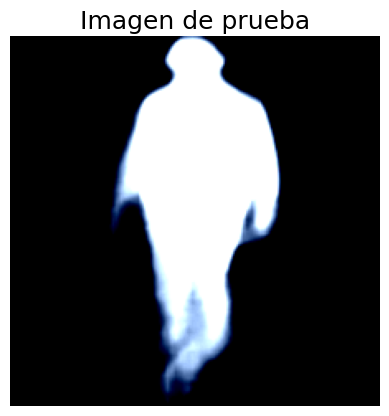

In [ ]:
# Tomar una imagen de validación
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        _ = model(images[:1])  # Usamos solo la primera imagen del batch
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.title("Imagen de prueba",fontsize=18)
        plt.axis('off')
        #plt.savefig("img_prueba_caracteristicas_resnet50.png",dpi=300,bbox_inches='tight')
        plt.show()
        break  # Solo una imagen es suficiente para visualización


Forma de los mapas de características: torch.Size([256, 56, 56])


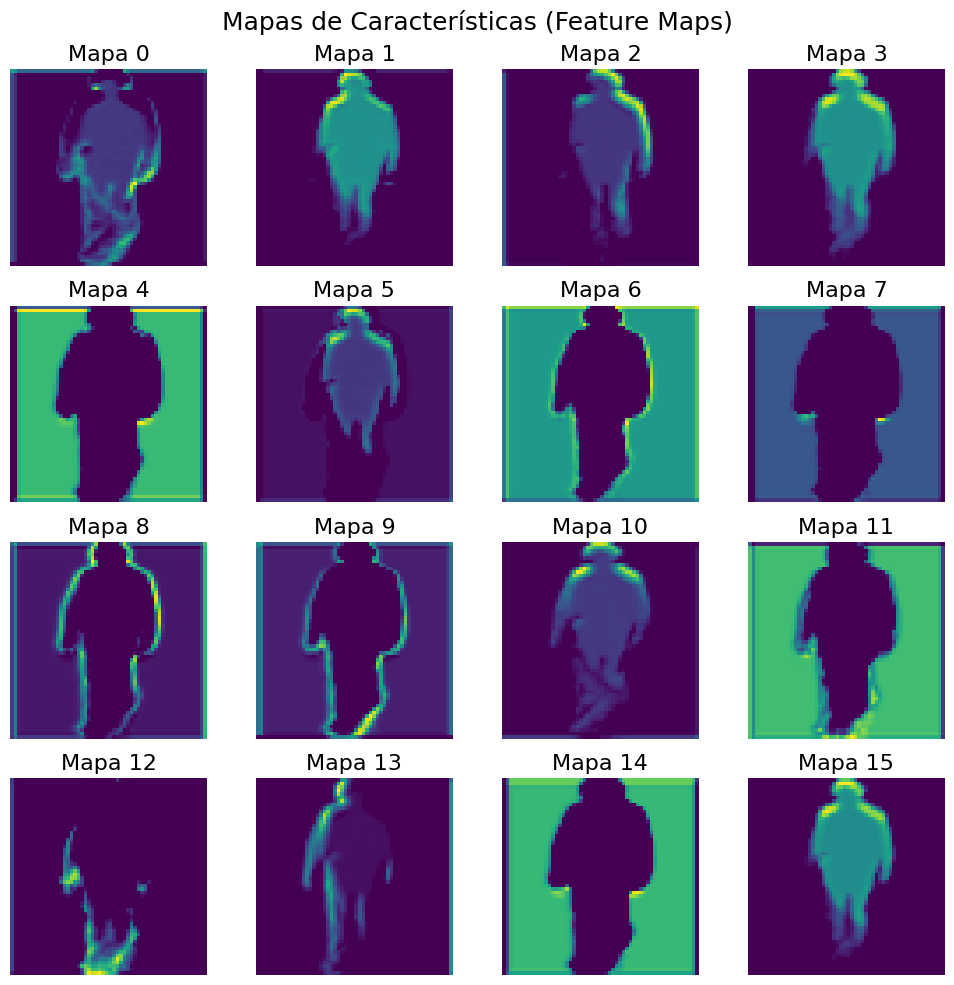

In [ ]:
# Obtenemos los feature maps capturados
feature_maps = activation_maps[0].squeeze(0)  # [C, H, W], sin batch dim
print("Forma de los mapas de características:", feature_maps.shape)

# Mostrar los primeros N mapas (canales)
num_maps_to_show = 16
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < feature_maps.shape[0]:
        ax.imshow(feature_maps[i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Mapa {i}",fontsize=16)
plt.suptitle("Mapas de Características (Feature Maps)",fontsize=18)
plt.tight_layout()
plt.savefig("mapas_car_resnet50_layer3.png",dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
# import os
# import matplotlib.pyplot as plt

# output_dir = "feature_maps"
# os.makedirs(output_dir, exist_ok=True)

# for i in range(num_maps_to_show):
#     plt.figure(figsize=(3, 3))
#     plt.imshow(feature_maps[i], cmap='viridis')
#     plt.axis('off')
#     plt.title(f"Mapa {i}")
#     plt.savefig(f"{output_dir}/mapa_{i}.png")
#     plt.close()


In [ ]:
# Imagen original sin normalizar (suponiendo que ya está en [0,1])
original_img = images[0].cpu()  # [3, H, W]
original_img = original_img.permute(1, 2, 0).numpy()  # [H, W, 3]
original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())


In [ ]:
# Usar el mapa promedio de activación
feature_map = activation_maps[0].squeeze(0)  # [C, H, W]
avg_map = feature_map.mean(dim=0).numpy()    # [H, W]

# Normalizar a [0, 1] para visualización
avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min())


In [ ]:
import cv2

# Redimensionar el mapa de activación al tamaño de la imagen original
H, W = original_img.shape[:2]
avg_map_resized = cv2.resize(avg_map, (W, H), interpolation=cv2.INTER_CUBIC)


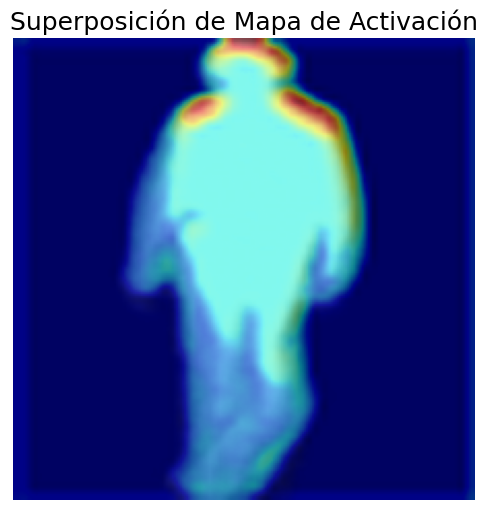

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(original_img)
plt.imshow(avg_map_resized, cmap='jet', alpha=0.5)  # el mapa encima, con transparencia
plt.title("Superposición de Mapa de Activación",fontsize=18)
plt.axis('off')
plt.savefig("mapas_car_1ind_resnet50_layer2.png",dpi=300,bbox_inches='tight')
plt.show()


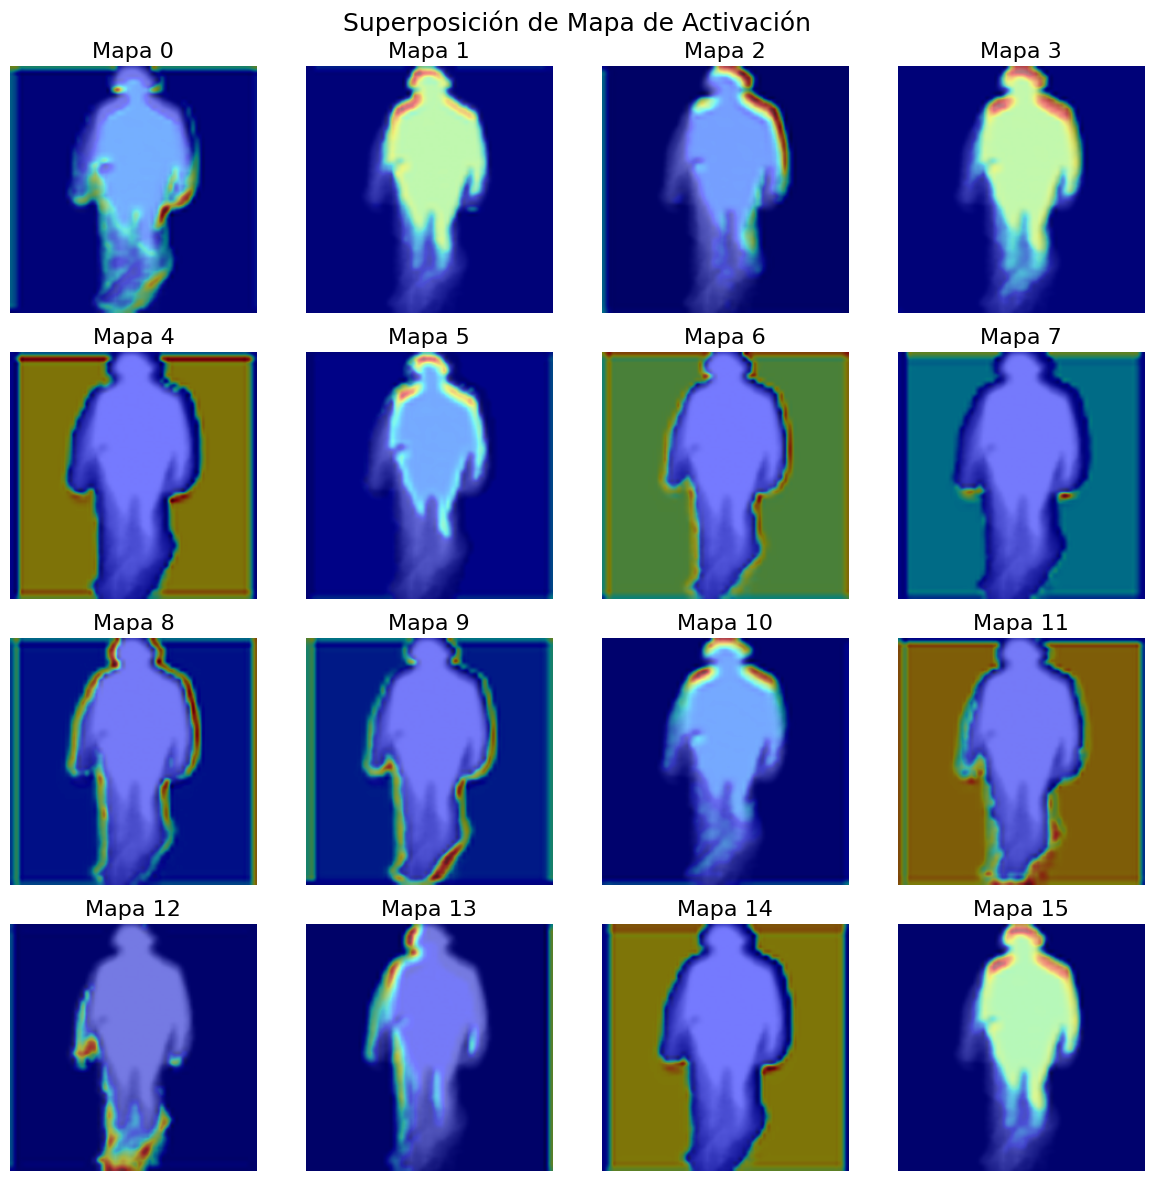

In [ ]:
# Usamos los 16 primeros canales
num_channels = 16
H, W = original_img.shape[:2]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(num_channels):
    ax = axes[i // 4, i % 4]

    # Extraer el canal i
    fmap = feature_map[i].numpy()
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)  # Normalizar

    # Redimensionar al tamaño de la imagen original
    fmap_resized = cv2.resize(fmap, (W, H), interpolation=cv2.INTER_CUBIC)

    # Mostrar imagen original + mapa superpuesto
    ax.imshow(original_img)
    ax.imshow(fmap_resized, cmap='jet', alpha=0.5)
    ax.set_title(f"Mapa {i}",fontsize=16)
    ax.axis('off')

plt.suptitle("Superposición de Mapa de Activación", fontsize=18)
plt.tight_layout()
plt.savefig("mapas_superpuestos_resnet50_layer2.png",dpi=300,bbox_inches='tight')
plt.show()

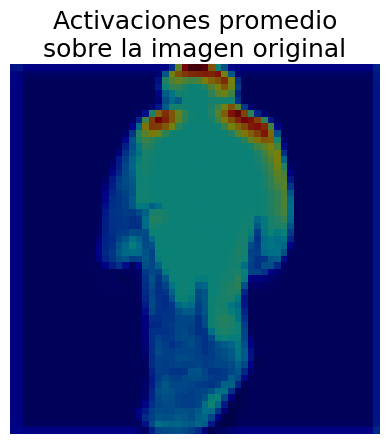

In [ ]:
import torchvision.transforms.functional as TF

# Imagen original (sin normalización)
original_img = images[0].cpu()
original_img = original_img.permute(1, 2, 0).numpy()
original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())

# Mapa de activación promedio
avg_map = feature_maps.mean(dim=0).numpy()
avg_map = (avg_map - avg_map.min()) / (avg_map.max() - avg_map.min())

plt.imshow(original_img)
plt.imshow(avg_map, cmap='jet', alpha=0.5)
plt.title("Activaciones promedio\nsobre la imagen original",fontsize=18)
plt.axis('off')
plt.savefig("filtros_act_prom_layer2_resnet50.png",dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
hook.remove()